[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/moshi4/pyCirclize/blob/main/docs/circos_plot.ipynb)

In [1]:
# %pip install pycirclize

## 1. Enterobacteria phage

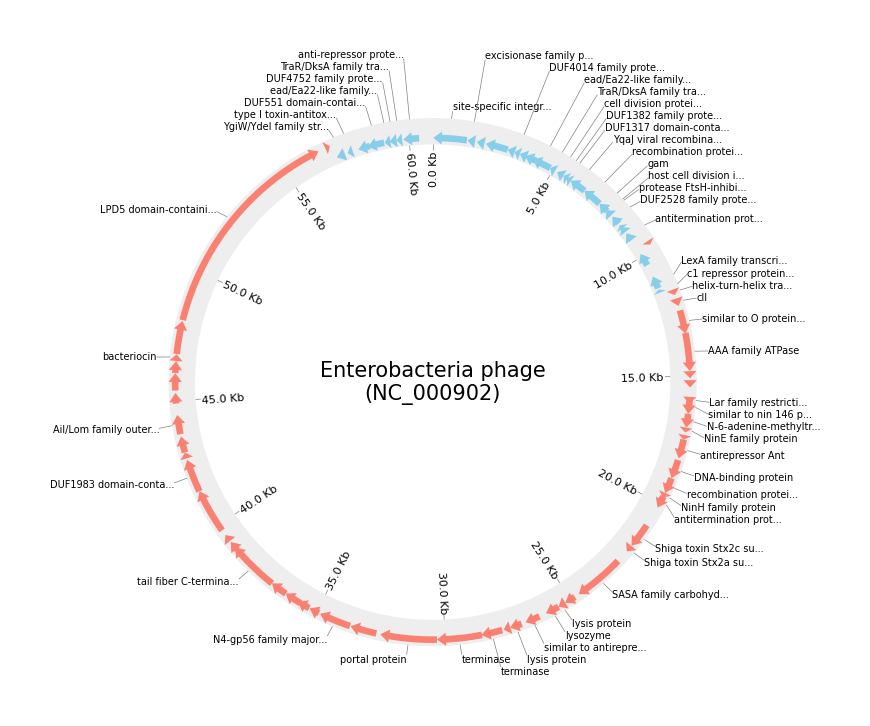

In [2]:
from pycirclize import Circos
from pycirclize.parser import Gff
from pycirclize.utils import load_prokaryote_example_file

# Load GFF file
gff_file = load_prokaryote_example_file("enterobacteria_phage.gff")
gff = Gff(gff_file)

# Initialize circos instance
seqid2size = gff.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)
circos.text("Enterobacteria phage\n(NC_000902)", size=15)

seqid2features = gff.get_seqid2features(feature_type="CDS")
for sector in circos.sectors:
    cds_track = sector.add_track((90, 100))
    cds_track.axis(fc="#EEEEEE", ec="none")

    features = seqid2features[sector.name]
    label_pos_list, labels = [], []
    for feature in features:
        # Plot CDS features
        if feature.location.strand == 1:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(95, 100), fc="salmon")
        else:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(90, 95), fc="skyblue")
        # Extract feature product label & position
        start, end = int(feature.location.start), int(feature.location.end)
        label_pos = (start + end) / 2
        label = feature.qualifiers.get("product", [""])[0]
        if label == "" or label.startswith("hypothetical"):
            continue
        cds_track.annotate(label_pos, label, label_size=7)

    # Plot xticks & intervals on inner position
    cds_track.xticks_by_interval(
        interval=5000,
        outer=False,
        label_formatter=lambda v: f"{v/ 1000:.1f} Kb",
        label_orientation="vertical",
        line_kws=dict(ec="grey"),
    )

fig = circos.plotfig()

## 2. Escherichia coli

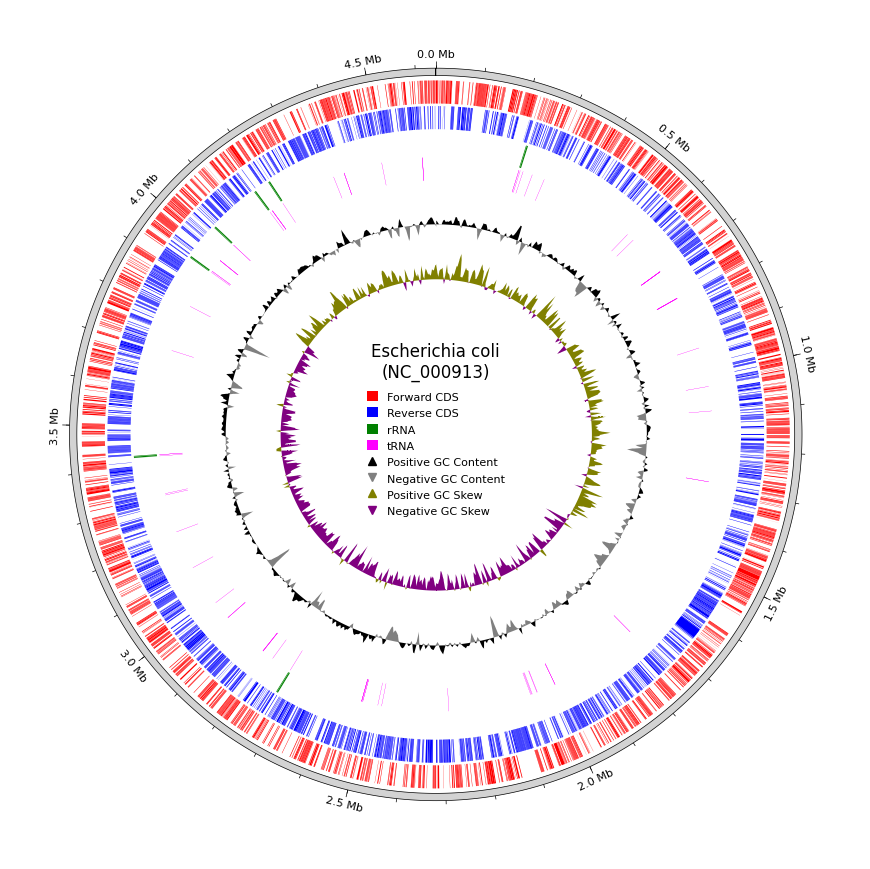

In [3]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Load Genbank file
gbk_file = load_prokaryote_example_file("escherichia_coli.gbk.gz")
gbk = Genbank(gbk_file)

# Initialize circos instance
seqid2size = gbk.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)
circos.text("Escherichia coli\n(NC_000913)", size=12, r=20)

seqid2features = gbk.get_seqid2features(feature_type=None)
seqid2seq = gbk.get_seqid2seq()
for sector in circos.sectors:
    # Plot outer track with xticks
    major_ticks_interval = 500000
    minor_ticks_interval = 100000
    outer_track = sector.add_track((98, 100))
    outer_track.axis(fc="lightgrey")
    if sector.size >= major_ticks_interval:
        outer_track.xticks_by_interval(
            major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
        )
        outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

    f_cds_track = sector.add_track((90, 97), r_pad_ratio=0.1)
    r_cds_track = sector.add_track((83, 90), r_pad_ratio=0.1)
    rrna_track = sector.add_track((76, 83), r_pad_ratio=0.1)
    trna_track = sector.add_track((69, 76), r_pad_ratio=0.1)

    # Plot Forward CDS, Reverse CDS, rRNA, tRNA
    features = seqid2features[sector.name]
    for feature in features:
        if feature.type == "CDS" and feature.location.strand == 1:
            f_cds_track.genomic_features(feature, fc="red")
        elif feature.type == "CDS" and feature.location.strand == -1:
            r_cds_track.genomic_features(feature, fc="blue")
        elif feature.type == "rRNA":
            rrna_track.genomic_features(feature, fc="green")
        elif feature.type == "tRNA":
            trna_track.genomic_features(feature, color="magenta", lw=0.1)

    # Plot GC content
    gc_content_track = sector.add_track((50, 65))
    seq = seqid2seq[sector.name]
    label_pos_list, gc_contents = gbk.calc_gc_content(seq=seq)
    gc_contents = gc_contents - gbk.calc_genome_gc_content(seq=gbk.full_genome_seq)
    positive_gc_contents = np.where(gc_contents > 0, gc_contents, 0)
    negative_gc_contents = np.where(gc_contents < 0, gc_contents, 0)
    abs_max_gc_content = np.max(np.abs(gc_contents))
    vmin, vmax = -abs_max_gc_content, abs_max_gc_content
    gc_content_track.fill_between(
        label_pos_list, positive_gc_contents, 0, vmin=vmin, vmax=vmax, color="black"
    )
    gc_content_track.fill_between(
        label_pos_list, negative_gc_contents, 0, vmin=vmin, vmax=vmax, color="grey"
    )

    # Plot GC skew
    gc_skew_track = sector.add_track((35, 50))

    label_pos_list, gc_skews = gbk.calc_gc_skew(seq=seq)
    positive_gc_skews = np.where(gc_skews > 0, gc_skews, 0)
    negative_gc_skews = np.where(gc_skews < 0, gc_skews, 0)
    abs_max_gc_skew = np.max(np.abs(gc_skews))
    vmin, vmax = -abs_max_gc_skew, abs_max_gc_skew
    gc_skew_track.fill_between(
        label_pos_list, positive_gc_skews, 0, vmin=vmin, vmax=vmax, color="olive"
    )
    gc_skew_track.fill_between(
        label_pos_list, negative_gc_skews, 0, vmin=vmin, vmax=vmax, color="purple"
    )

fig = circos.plotfig()

# Add legend
handles = [
    Patch(color="red", label="Forward CDS"),
    Patch(color="blue", label="Reverse CDS"),
    Patch(color="green", label="rRNA"),
    Patch(color="magenta", label="tRNA"),
    Line2D([], [], color="black", label="Positive GC Content", marker="^", ms=6, ls="None"),
    Line2D([], [], color="grey", label="Negative GC Content", marker="v", ms=6, ls="None"),
    Line2D([], [], color="olive", label="Positive GC Skew", marker="^", ms=6, ls="None"),
    Line2D([], [], color="purple", label="Negative GC Skew", marker="v", ms=6, ls="None"),
]
_ = circos.ax.legend(handles=handles, bbox_to_anchor=(0.5, 0.475), loc="center", fontsize=8)

## 3. Mycoplasma alvi

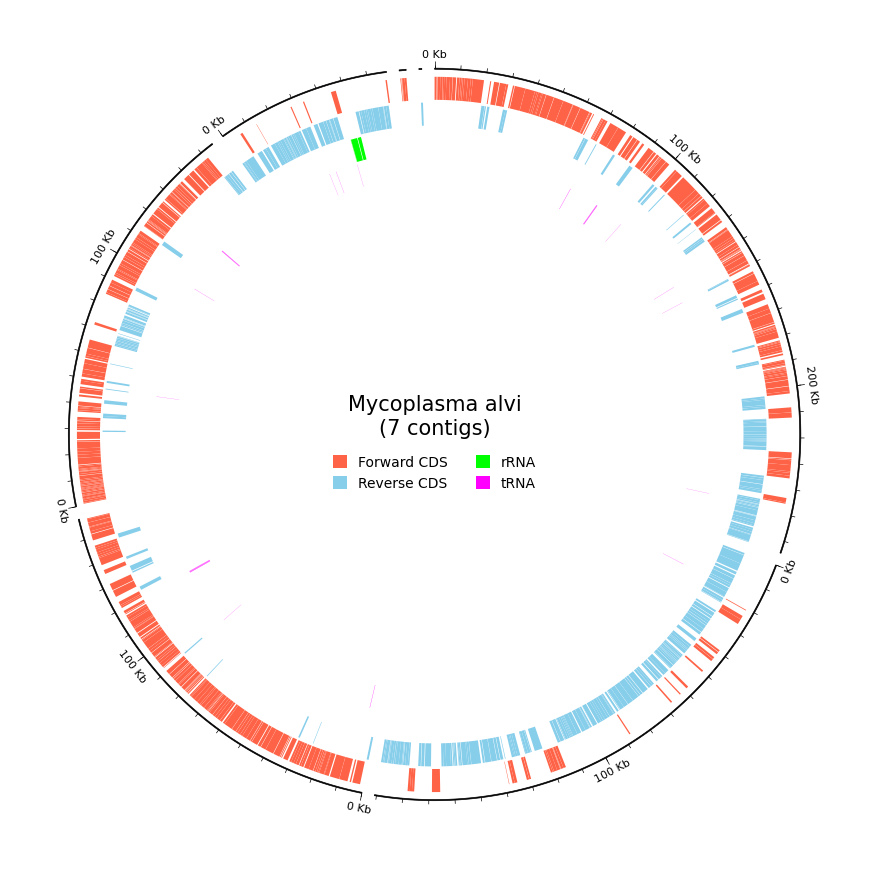

In [4]:
from pycirclize import Circos
from pycirclize.parser import Gff, Genbank
from pycirclize.utils import load_prokaryote_example_file
from matplotlib.patches import Patch

# Case1. Load `GFF` contig genomes
# https://github.com/moshi4/pycirclize-data/blob/main/prokaryote/mycoplasma_alvi.gff
gff_file = load_prokaryote_example_file("mycoplasma_alvi.gff")
parser = Gff(gff_file)

# Case2. Load `Genbank` contig genomes
# https://github.com/moshi4/pycirclize-data/blob/main/prokaryote/mycoplasma_alvi.gbk
# gbk_file = load_prokaryote_example_file("mycoplasma_alvi.gbk")
# parser = Genbank(gbk_file)

# Initialize circos instance
seqid2size = parser.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(seqid2size, space=space)
circos.text(f"Mycoplasma alvi\n({len(circos.sectors)} contigs)", r=5, size=15)

seqid2features = parser.get_seqid2features(feature_type=None)
for sector in circos.sectors:
    # Plot outer track
    outer_track = sector.add_track((99.7, 100))
    outer_track.axis(fc="black")
    major_interval = 100000
    minor_interval = int(major_interval / 10)
    if sector.size > minor_interval:
        outer_track.xticks_by_interval(major_interval, label_formatter=lambda v: f"{v / 1000:.0f} Kb")
        outer_track.xticks_by_interval(minor_interval, tick_length=1, show_label=False)

    # Plot forward/reverse CDS, rRNA, tRNA tracks
    f_cds_track = sector.add_track((91, 98), r_pad_ratio=0.1)
    r_cds_track = sector.add_track((84, 91), r_pad_ratio=0.1)
    rrna_track = sector.add_track((77, 84), r_pad_ratio=0.1)
    trna_track = sector.add_track((70, 77), r_pad_ratio=0.1)
    for feature in seqid2features[sector.name]:
        if feature.type == "CDS":
            if feature.location.strand == 1:
                f_cds_track.genomic_features([feature], fc="tomato")
            else:
                r_cds_track.genomic_features([feature], fc="skyblue")
        elif feature.type == "rRNA":
            rrna_track.genomic_features([feature], fc="lime")
        elif feature.type == "tRNA":
            trna_track.genomic_features([feature], fc="magenta")

fig = circos.plotfig()
_ = circos.ax.legend(
    handles=[
        Patch(color="tomato", label="Forward CDS"),
        Patch(color="skyblue", label="Reverse CDS"),
        Patch(color="lime", label="rRNA"),
        Patch(color="magenta", label="tRNA"),
    ],
    bbox_to_anchor=(0.5, 0.45),
    loc="center",
    ncols=2,
)

## 4. Homo sapiens (hg38)

**hg38** data files are obtained from [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables).

Dataset Repository:  
https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38

### 4-1. Ideograms

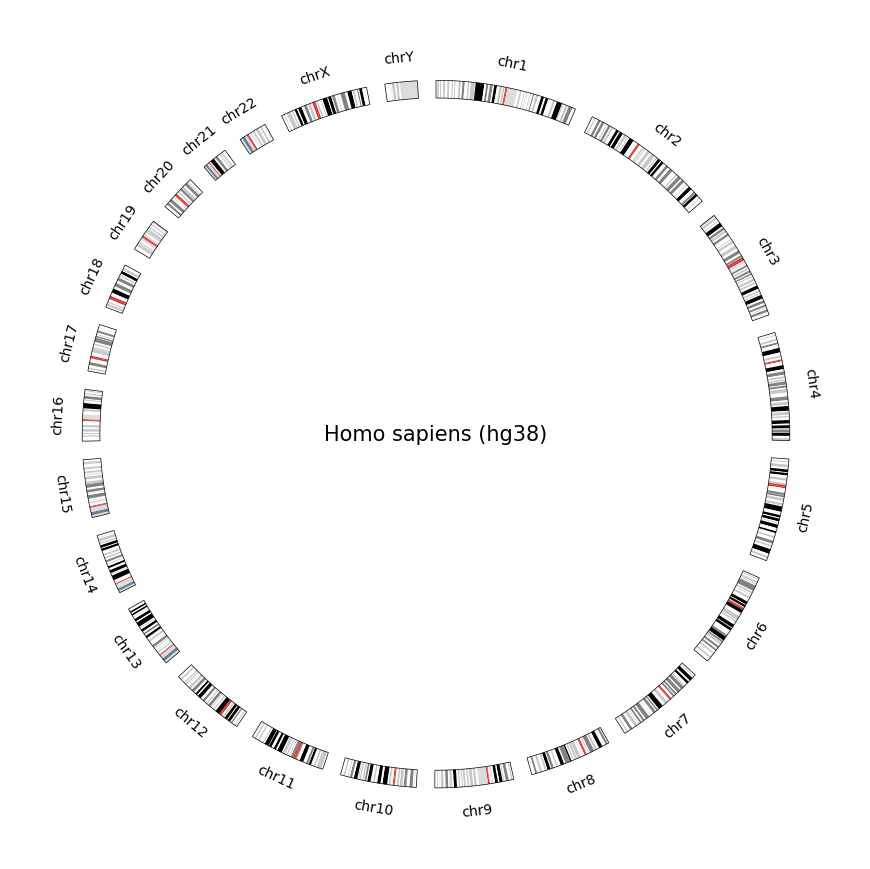

In [5]:
from pycirclize import Circos
from pycirclize.utils import load_eukaryote_example_dataset

# Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38)
chr_bed_file, cytoband_file, _ = load_eukaryote_example_dataset("hg38")

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Homo sapiens (hg38)", size=15)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Plot chromosome name
for sector in circos.sectors:
    sector.text(sector.name, size=10)

fig = circos.plotfig()

### 4-2. Segmental Dups Link

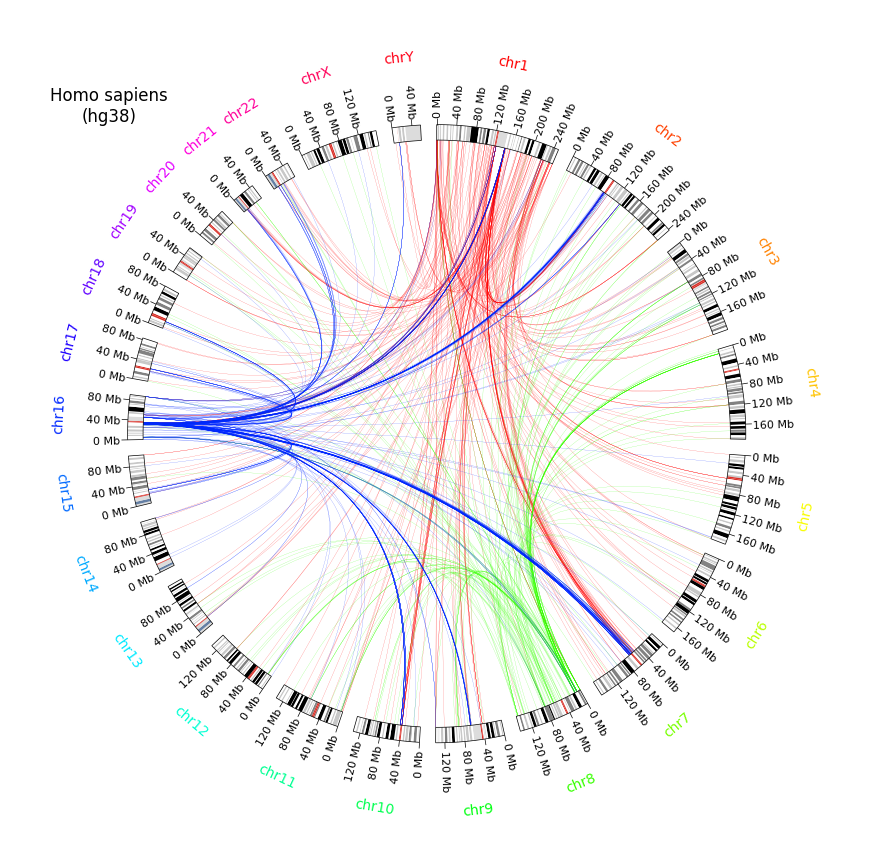

In [6]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset

# Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38)
chr_bed_file, cytoband_file, chr_links = load_eukaryote_example_dataset("hg38")

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Homo sapiens\n(hg38)", deg=315, r=150, size=12)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Create chromosome color dict
ColorCycler.set_cmap("hsv")
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

# Plot chromosome name & xticks
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=10, color=chr_name2color[sector.name])
    sector.get_track("cytoband").xticks_by_interval(
        40000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb",
    )

# Plot chromosome link
for link in chr_links:
    region1 = (link.query_chr, link.query_start, link.query_end)
    region2 = (link.ref_chr, link.ref_start, link.ref_end)
    color = chr_name2color[link.query_chr]
    if link.query_chr in ("chr1", "chr8", "chr16") and link.query_chr != link.ref_chr:
        circos.link(region1, region2, color=color)

fig = circos.plotfig()

### 4-3. Plot Graphs

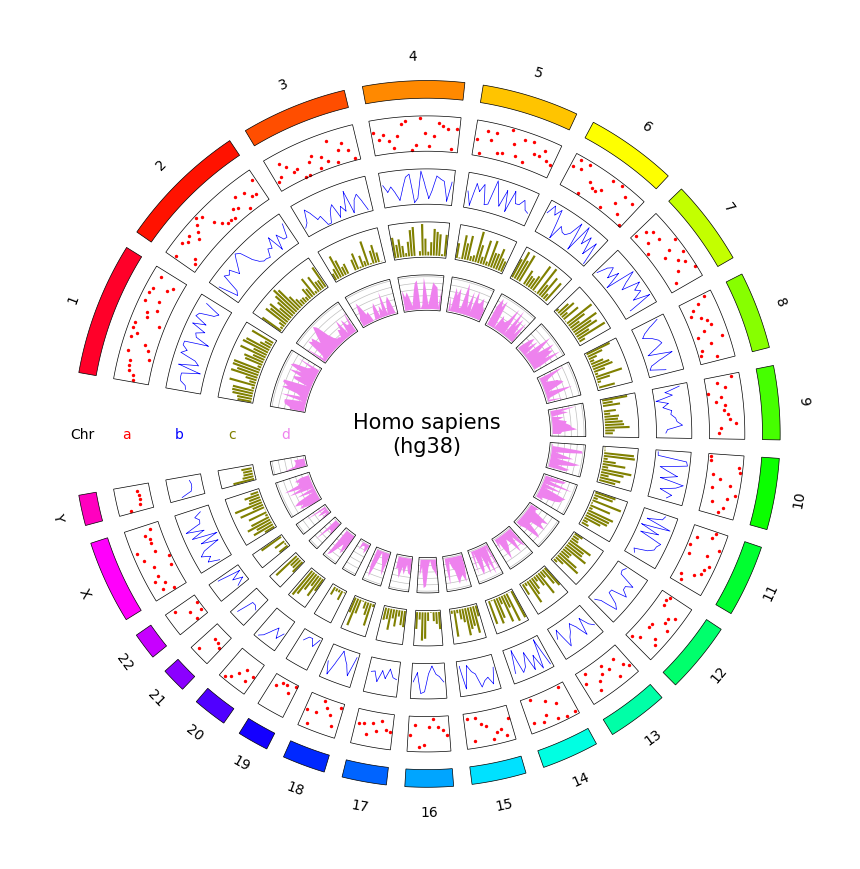

In [7]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset
import numpy as np
np.random.seed(0)

# Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38)
chr_bed_file = load_eukaryote_example_dataset("hg38")[0]

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, start=-80, end=260, space=3, endspace=False)
circos.text("Homo sapiens\n(hg38)", size=15)

# Create chromosome color dict
ColorCycler.set_cmap("gist_rainbow")
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

for sector in circos.sectors:
    # Plot chromosome outer track
    sector.text(sector.name.replace("chr", ""))
    color = chr_name2color[sector.name]
    outer_track = sector.add_track((95, 100))
    outer_track.axis(fc=color)
    # Create example x,y plot data
    step = 10000000
    x = np.arange(sector.start + (step / 2), sector.end - (step / 2), step)
    y = np.random.randint(0, 100, size=len(x))
    # Scatter track
    track1 = sector.add_track((80, 90), r_pad_ratio=0.1)
    track1.axis()
    track1.scatter(x, y, vmax=100, s=6, color="red")
    # Line track
    track2 = sector.add_track((65, 75), r_pad_ratio=0.1)
    track2.axis()
    track2.line(x, y, vmax=100, color="blue")
    # Bar track
    track3 = sector.add_track((50, 60), r_pad_ratio=0.1)
    track3.axis()
    track3.bar(x, y, vmax=100, width=step * 0.7, color="olive")
    # Fill between track
    track4 = sector.add_track((35, 45), r_pad_ratio=0.1)
    track4.axis()
    track4.grid()
    track4.fill_between(x, y, vmax=100, color="violet")
    # Plot track labels
    if sector.name == circos.sectors[0].name:
        circos.text("Chr", r=outer_track.r_center, deg=-90)
        circos.text("a", r=track1.r_center, deg=-90, color="red")
        circos.text("b", r=track2.r_center, deg=-90, color="blue")
        circos.text("c", r=track3.r_center, deg=-90, color="olive")
        circos.text("d", r=track4.r_center, deg=-90, color="violet")

fig = circos.plotfig()

## 5. Mus musculus (mm10)

**mm10** data files are obtained from [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables).

Dataset Repository:  
https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/mm10

### 5-1. Ideograms

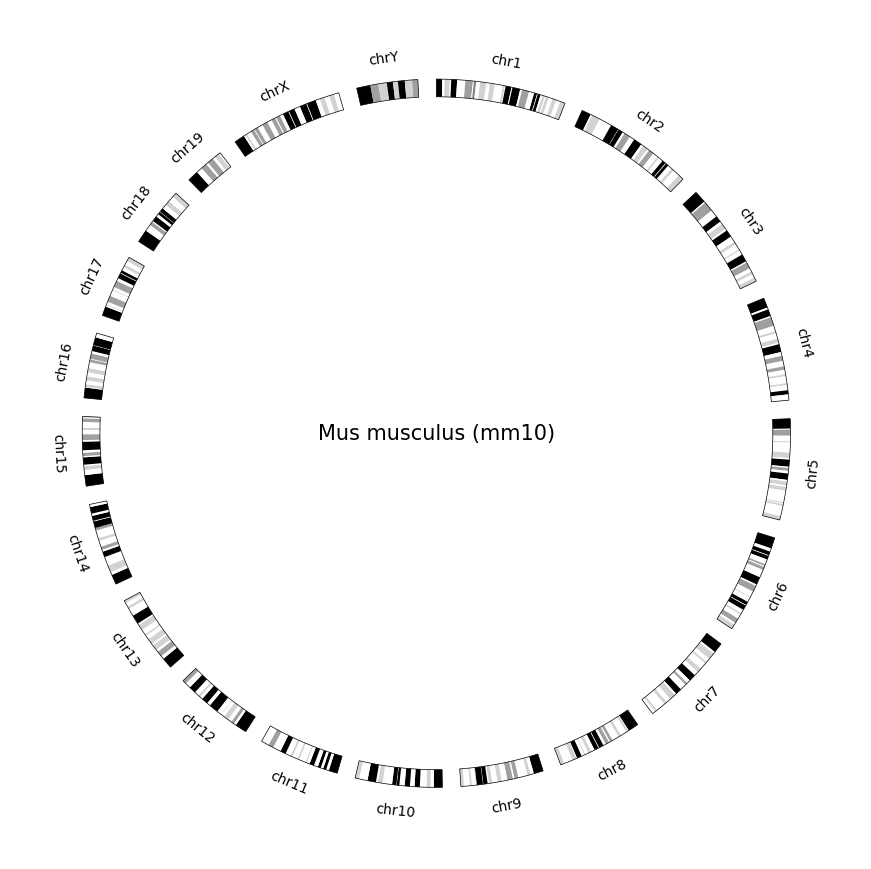

In [8]:
from pycirclize import Circos
from pycirclize.utils import load_eukaryote_example_dataset

# Load mm10 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/mm10)
chr_bed_file, cytoband_file, _ = load_eukaryote_example_dataset("mm10")

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Mus musculus (mm10)", size=15)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Plot chromosome name
for sector in circos.sectors:
    sector.text(sector.name, size=10)

fig = circos.plotfig()

### 5-2. Segmental Dups Link

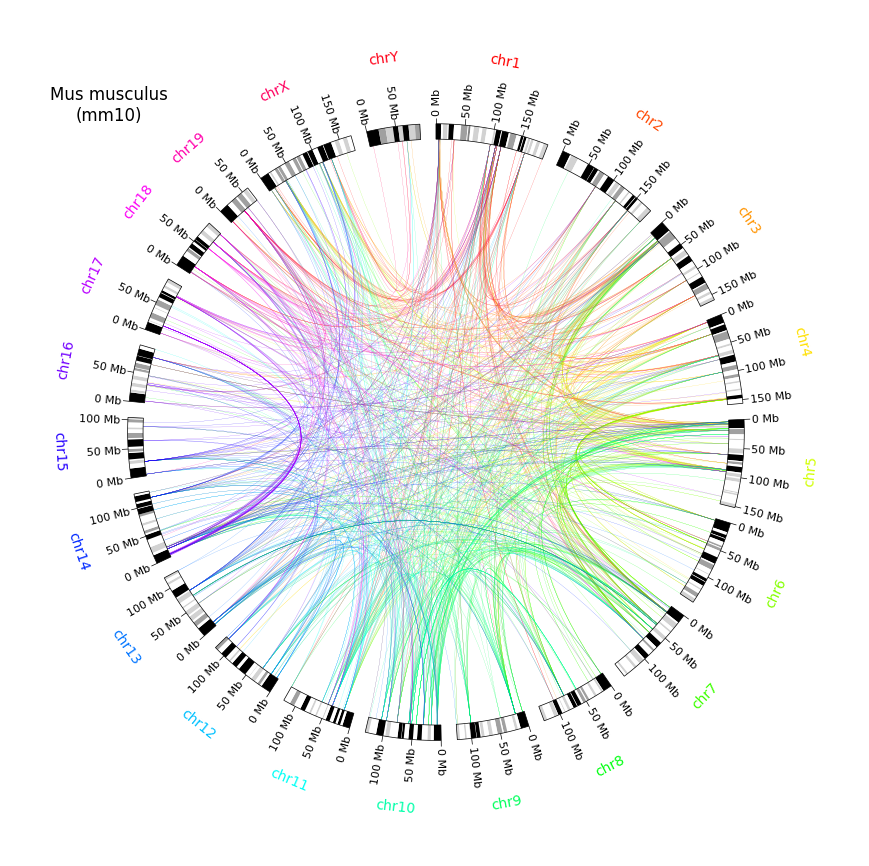

In [9]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset

# Load mm10 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/mm10)
chr_bed_file, cytoband_file, chr_links = load_eukaryote_example_dataset("mm10")

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=3)
circos.text("Mus musculus\n(mm10)", deg=315, r=150, size=12)

# Add cytoband tracks from cytoband file
circos.add_cytoband_tracks((95, 100), cytoband_file)

# Create chromosome color mapping
ColorCycler.set_cmap("hsv")
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

# Plot chromosome name & xticks
for sector in circos.sectors:
    sector.text(sector.name, r=120, size=10, color=chr_name2color[sector.name])
    sector.get_track("cytoband").xticks_by_interval(
        50000000,
        label_size=8,
        label_orientation="vertical",
        label_formatter=lambda v: f"{v / 1000000:.0f} Mb",
    )

# Plot chromosome link
for link in chr_links:
    region1 = (link.query_chr, link.query_start, link.query_end)
    region2 = (link.ref_chr, link.ref_start, link.ref_end)
    color = chr_name2color[link.query_chr]
    if link.query_chr != link.ref_chr:
        circos.link(region1, region2, color=color)

fig = circos.plotfig()

### 5-3. Plot Heatmaps

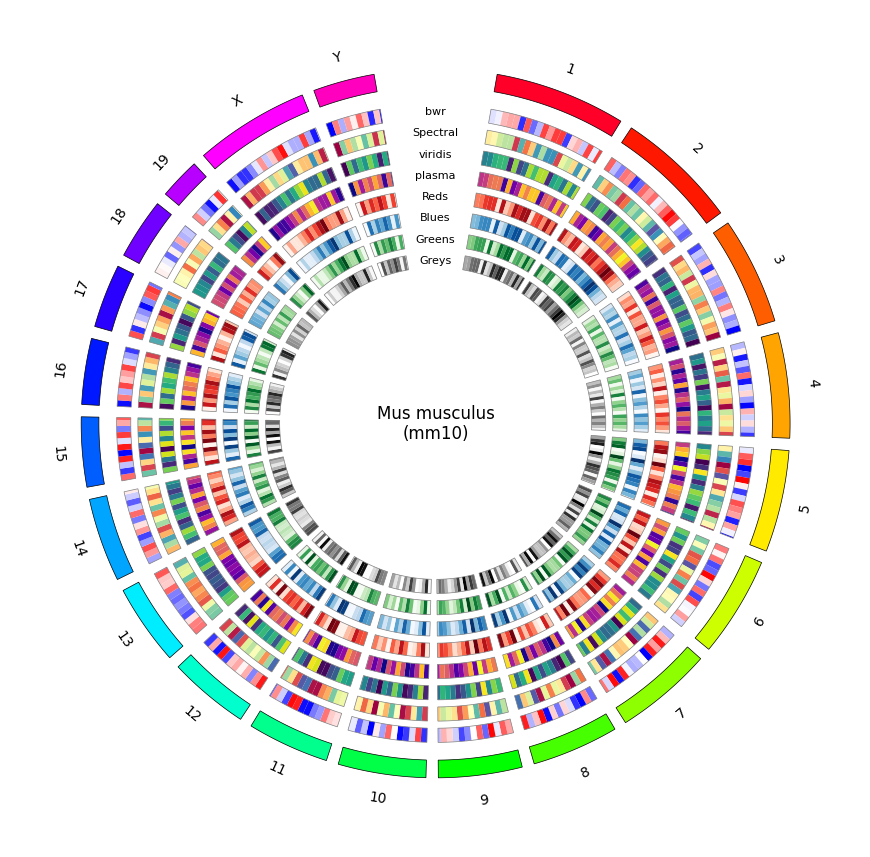

In [10]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset
import numpy as np
np.random.seed(0)

# Load mm10 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/mm10)
chr_bed_file = load_eukaryote_example_dataset("mm10")[0]

# Initialize Circos from BED chromosomes
circos = Circos.initialize_from_bed(chr_bed_file, space=2, start=10, end=350, endspace=False)
circos.text("Mus musculus\n(mm10)", size=12)

heatmap_cmaps = ["bwr", "Spectral", "viridis", "plasma", "Reds", "Blues", "Greens", "Greys"]
ColorCycler.set_cmap("gist_rainbow")
colors = ColorCycler.get_color_list(len(circos.sectors))
for sector, color in zip(circos.sectors, colors):
    sector.text(sector.name.replace("chr", ""), size=10)
    # Plot chromosome outer track
    chr_track = sector.add_track((95, 100))
    chr_track.axis(fc=color)
    # Create random test data for heatmap plot
    window_size = 10_000_000
    data_num = int(sector.size // window_size) + 1
    vmin, vmax = 0, 100
    data = np.random.randint(vmin, vmax, data_num)
    # Plot heatmap tracks with various cmap
    track_r_size, r_interval, r_start = 4, 2, 90
    for idx, cmap in enumerate(heatmap_cmaps):
        r_pos = r_start - (track_r_size + r_interval) * idx
        track_r_lim = (r_pos - track_r_size, r_pos)
        track = sector.add_track(track_r_lim)
        track.axis(ec="grey")
        track.heatmap(data, width=window_size, vmin=vmin, vmax=vmax, cmap=cmap)
        # Plot colormap name on center
        if sector.name == circos.sectors[0].name:
            circos.text(cmap, r=track.r_center, size=8)

fig = circos.plotfig()